## Import Necessary Libraries/Packages

In [1]:
import pandas as pd
import numpy as np
import string

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer as vs

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Read the dataset as train_df and test_df

In [2]:
train_df = pd.read_csv("gabb_reddit_train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35635 entries, 0 to 35634
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  35339 non-null  object
 1   Label    35635 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 556.9+ KB


In [3]:
test_df = pd.read_csv("gabb_reddit_test.csv")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8910 entries, 0 to 8909
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  8822 non-null   object
 1   Label    8910 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 139.3+ KB


## Data Preprocessing

In [4]:
# Removing missing items
test_df = test_df.dropna()
test_df.info()
train_df = train_df.dropna()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8822 entries, 0 to 8909
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  8822 non-null   object
 1   Label    8822 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 206.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 35339 entries, 0 to 35634
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Content  35339 non-null  object
 1   Label    35339 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 828.3+ KB


In [5]:
# create a new dataframe merging train and test data
df = pd.DataFrame()
df = df.append(train_df)
df = df.append(test_df)
df = df.reset_index(drop=True)


,Content,Label
0,of course,0
1,that s because you never go full retard,1
2,no i use reflection not projection wake up neo...,0
3,youre not the only one but from a guitar persp...,0
4,don t trust that vagina for killing those plan...,1
...,...,...
44156,wearing a badge does not mean that assault law...,0
44157,actually retarded is not catching satire,0
44158,sadder that people will see it spelled out and...,0
44159,malala is a bit of a cunt she is genuinely not...,1


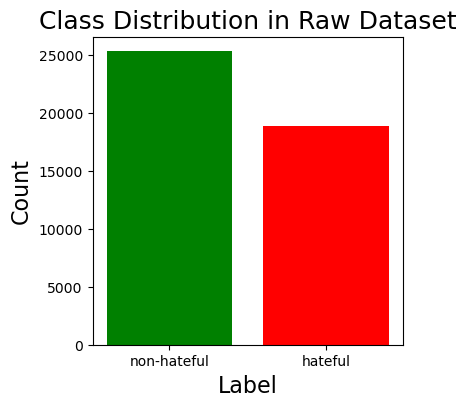

In [6]:
# Count the number of instances in each class
class_x_count = len(df[df['Label'] == 0])
class_y_count = len(df[df['Label'] == 1])

# Create bar chart
plt.figure(figsize=(4, 4))
plt.bar(['non-hateful', 'hateful'], [class_x_count, class_y_count], color=['green', 'red'])

# Set axis labels
plt.xlabel('Label', fontsize = 16)
plt.ylabel('Count', fontsize = 16)
plt.title('Class Distribution in Raw Dataset', fontsize = 18)
# Show plot
plt.show()


In [7]:
# collecting only the tweets from the csv file into a variable name tweet
content = df.Content

In [8]:
content.head(2)

0                                  of course
1    that s because you never go full retard
Name: Content, dtype: object

In [9]:
word_count = 0
for i in range(len(content)):
    words = content[i].split()
#     print(words)
#     print(len(words))
    word_count += len(words)
print(word_count)
#     break

1480945


## Download English stopwords

In [10]:
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Israt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Cleaning

In [11]:
# In this section we will do the following tasks:
    # 1. Get rid of punctuation and capitlization
    # 2. Tokenizing
    # 3. Removal of stopwords
    # 4. Stemming


#extending the stopwords to include other words 
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

def preprocess(content):  
    
    # remove extra spaces, @, links, punctuaions, numbers, single space, leading and trainling zero
    # replace normal numbers with numbr
    regex_space = re.compile(r'\s+')
    content_space = content.str.replace(regex_space, ' ')
    
    regex_space = re.compile(r'@[\w\-]+') # space
    content_name = content_space.str.replace(regex_space, '')

    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|' '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    contents = content_name.str.replace(giant_url_regex, '')
        
    punc_remove = contents.str.replace("[^a-zA-Z]", " ") # punctuations and numbers
    
    new_content = punc_remove.str.replace(r'\s+', ' ') # single space 
    
    new_content = new_content.str.replace(r'^\s+|\s+?$','') # leading and trainling white space
    
    new_content = new_content.str.replace(r'\d+(\.\d+)?','numbr') # replace numbers
    
    content_lower = new_content.str.lower() # convert to lower case
    
    tokenized_content = content_lower.apply(lambda x: x.split()) # tokenizing 
    
    tokenized_content=  tokenized_content.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming the contents
    tokenized_content = tokenized_content.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    for i in range(len(tokenized_content)):
        tokenized_content[i] = ' '.join(tokenized_content[i])
        processed_content = tokenized_content
    
    return processed_content

processed_contents = preprocess(content)   

df['processed_contents'] = processed_contents
print(df[["Content","processed_contents"]].head(10))


                                             Content  \
0                                          of course   
1            that s because you never go full retard   
2  no i use reflection not projection wake up neo...   
3  youre not the only one but from a guitar persp...   
4  don t trust that vagina for killing those plan...   
5  of the population of do not care voted for hil...   
6  might be trying to tell you one of them muzzie...   
7  this nazi vagina just shot up a synagogue in m...   
8  maybe if these stupid whores would just stop m...   
9  all of americas problems can be traced to the ...   

                                  processed_contents  
0                                              cours  
1                               never go full retard  
2  use reflect project wake neo trump maga kag ga...  
3  your one guitar perspect realli slut unbeliev ...  
4                     trust vagina kill plant reason  
5  popul care vote hillari clinton whatev suppos ... 

## visualizing most commonly used words in the dataset

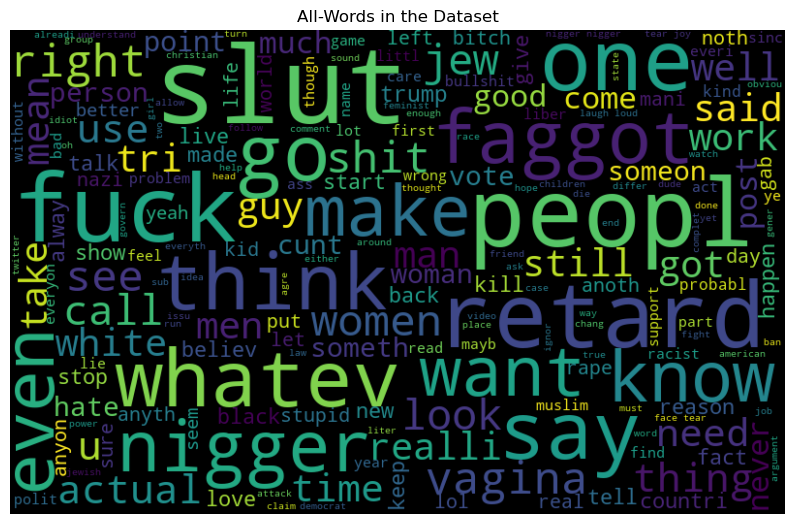

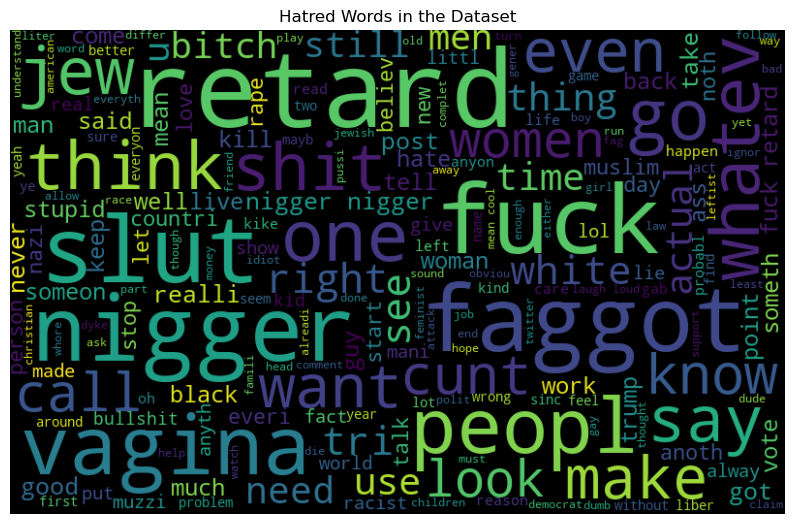

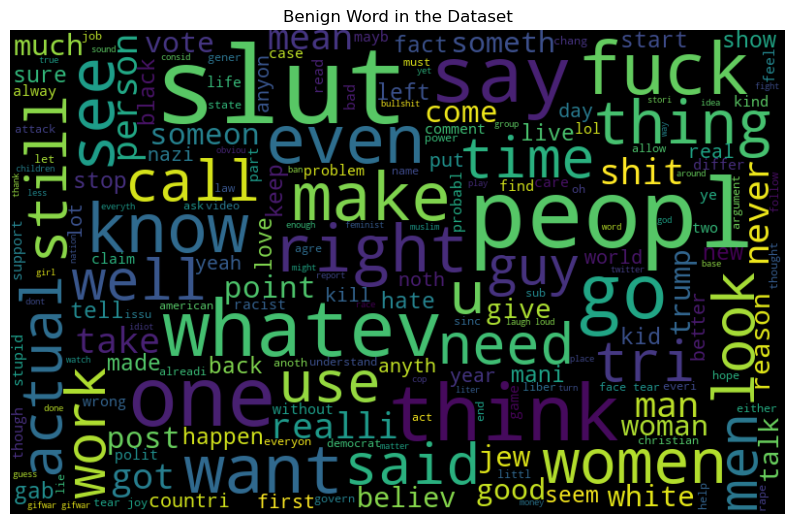

In [12]:
# visualizing all words in the dataset with word cloud
words = ' '.join([text for text in df['processed_contents'] ])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All-Words in the Dataset')
plt.show()

# visualizing most commonly used  words for hatred speech
hatred_words = ' '.join([text for text in df['processed_contents'][df['Label'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(hatred_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Hatred Words in the Dataset')
plt.axis('off')
plt.show()

# visualizing most commonly used benign words
benign_words = ' '.join([text for text in df['processed_contents'][df['Label'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=110).generate(benign_words)
plt.figure(figsize=(10, 7))
plt.title('Benign Word in the Dataset')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Feature Engineering: TF-IDF

In [13]:
# we will use TF-IDF and Sentiment Analysis for our modeling purpose

In [14]:
# create a dataset to store the performance metrics
df_metrics = pd.DataFrame(data = {'Model':[], 'Feature':[], 'Precision':[], 'Recall':[], 'F-1_Score':[], 'Accuracy':[]})
idx = 0

In [15]:
#TF-IDF 
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(df['processed_contents'] )
tfidf

<44161x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 725820 stored elements in Compressed Sparse Row format>

In [16]:
# get the feature names and check the number of features
feature_names = sorted(tfidf_vectorizer.vocabulary_.keys(), key=lambda x: tfidf_vectorizer.vocabulary_[x])
num_features = len(feature_names)
print("Number of features:", num_features)

Number of features: 10000


## Model Implementation: Logistic Regression

In [17]:
X = tfidf
y = df['Label'].astype(int)

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# train the model with Logistic Regression model
model = LogisticRegression().fit(X_train,y_train)

y_preds = model.predict(X_test)

# performance metrics
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

df_metrics.loc[idx] = ['LogisticRegression', 'td-idf', precision, recall, f1, accuracy]

In [18]:
# confusion metrix for Logistic Regression
confusion_matrix1 = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix1[i,:]/float(confusion_matrix1[i,:].sum())
names=['Hateful','Non-Hateful']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)

## Model implementation: Random Forest Classifier

In [19]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# train the model with Random Forest Model
rf=RandomForestClassifier().fit(X_train_tfidf,y_train)

y_preds = rf.predict(X_test_tfidf)

# performance metrics
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx+=1
df_metrics.loc[idx] = ['RandomForestClassifier', 'td-idf', precision, recall, f1, accuracy]

In [20]:
# confusion matrix for Random Forest Classifier
confusion_matrix1 = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix1[i,:]/float(confusion_matrix1[i,:].sum())
names=['Hateful','Non-Hateful']
confusion_df1 = pd.DataFrame(matrix_proportions, index=names,columns=names)

## Model Implementation: Naive Bayes Classifier

In [21]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2)

# train the model withh Naive-Based model
nb=GaussianNB().fit(X_train_tfidf,y_train)

y_preds = nb.predict(X_test_tfidf)

# performance metrics
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx+=1
df_metrics.loc[idx] = ['Naive-Bayes', 'td-idf', precision, recall, f1, accuracy]

In [22]:
# confusion metrix for Naive Bayes Classifier
confusion_matrix1 = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix1[i,:]/float(confusion_matrix1[i,:].sum())
names=['Hateful','Non-Hateful']
confusion_df2 = pd.DataFrame(matrix_proportions, index=names,columns=names)

## Model Implementation: SVM Classifier

In [23]:
# train the model with support vector machine
support =LinearSVC(random_state=20).fit(X_train_tfidf,y_train)

y_preds = support.predict(X_test_tfidf)

# performance metrics
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx+=1
df_metrics.loc[idx] = ['SVM', 'td-idf', precision, recall, f1, accuracy]

In [24]:
# confusion metrix for SVM
confusion_matrix1 = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix1[i,:]/float(confusion_matrix1[i,:].sum())
names=['Hateful','Non-Hateful']
confusion_df3 = pd.DataFrame(matrix_proportions, index=names,columns=names)

## Performance Measurement for tf-idf

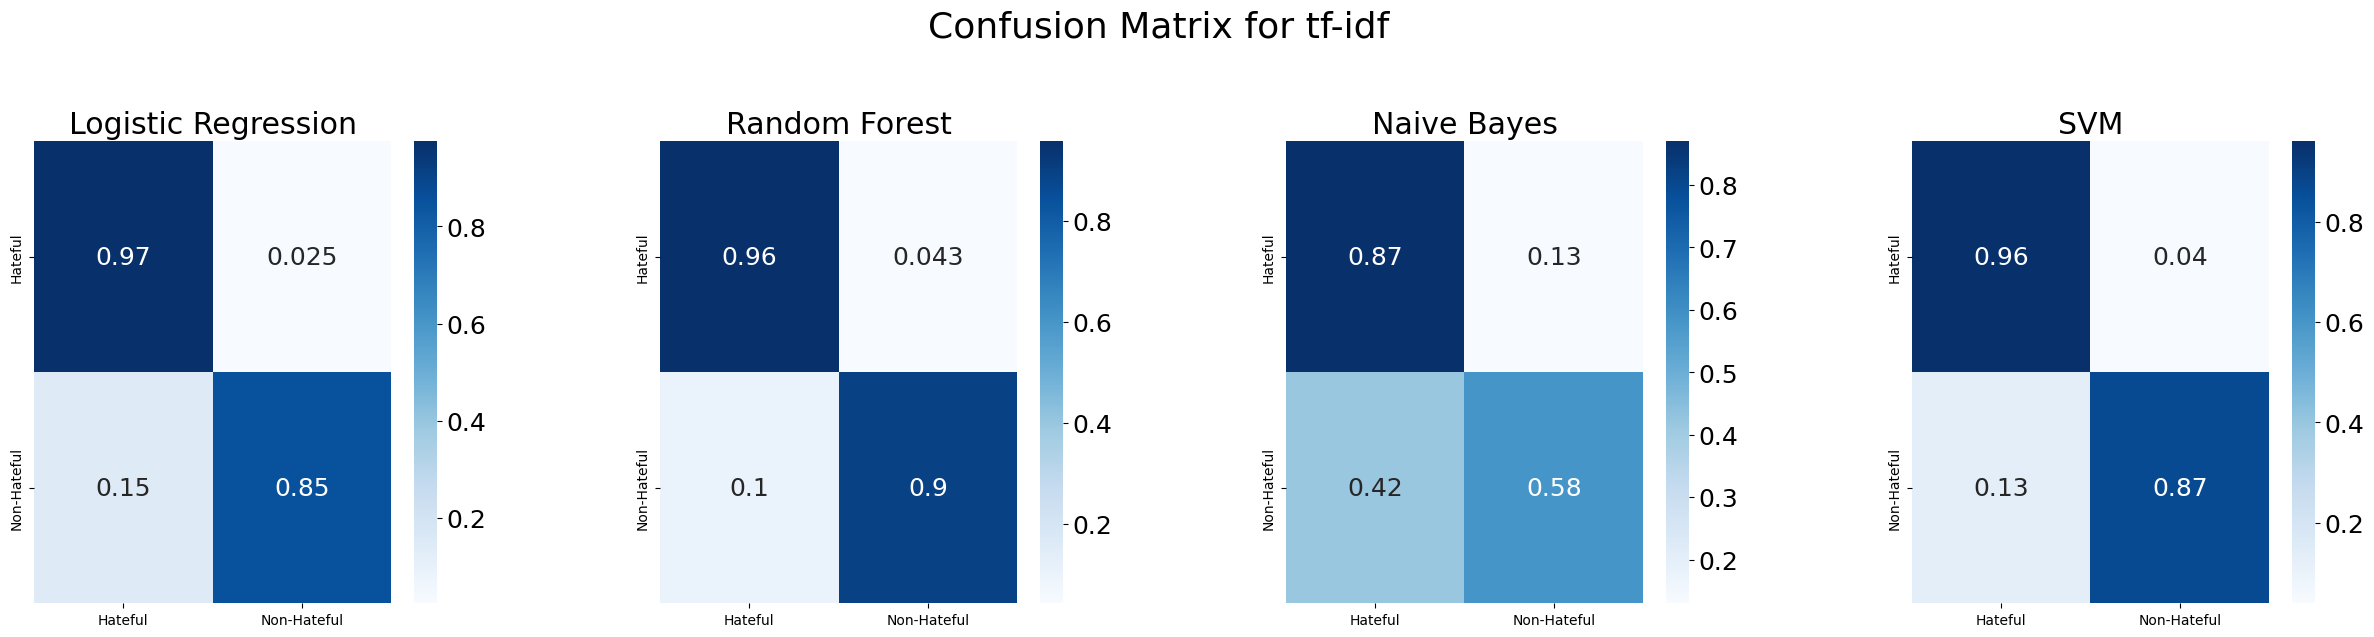

In [25]:
# Create a figure with four subplots in a row
fig, axs = plt.subplots(1, 4, figsize=(30, 6 ))

# Set the font size
plt.rcParams.update({'font.size': 18})

# Plot each confusion matrix on a separate subplot
sns.heatmap(confusion_df, annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(confusion_df1, annot=True, cmap='Blues', ax=axs[1])
sns.heatmap(confusion_df2, annot=True, cmap='Blues', ax=axs[2])
sns.heatmap(confusion_df3, annot=True, cmap='Blues', ax=axs[3])

# Set titles for each subplot
axs[0].set_title('Logistic Regression')
axs[1].set_title('Random Forest')
axs[2].set_title('Naive Bayes')
axs[3].set_title('SVM')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace = 0.4)
plt.savefig('tf_idf_confusion.png')

# Show the plot
fig.suptitle('Confusion Matrix for tf-idf', fontsize = 26, y = 1.1)
plt.show()


In [26]:
df_metrics

,Model,Feature,Precision,Recall,F-1_Score,Accuracy
0,LogisticRegression,td-idf,0.962567,0.852632,0.904270,0.922337
1,RandomForestClassifier,td-idf,0.939829,0.896053,0.917419,0.930601
2,Naive-Bayes,td-idf,0.771648,0.581579,0.663265,0.745953
3,SVM,td-idf,0.942637,0.869211,0.904436,0.920978


In [27]:
df_metrics2 = pd.DataFrame()
df_metrics2 = df_metrics2.append(df_metrics)

In [28]:
df_metrics3 = df_metrics2[['Model', 'Precision', 'Recall', 'F-1_Score', 'Accuracy']]
df_metrics3

,Model,Precision,Recall,F-1_Score,Accuracy
0,LogisticRegression,0.962567,0.852632,0.904270,0.922337
1,RandomForestClassifier,0.939829,0.896053,0.917419,0.930601
2,Naive-Bayes,0.771648,0.581579,0.663265,0.745953
3,SVM,0.942637,0.869211,0.904436,0.920978


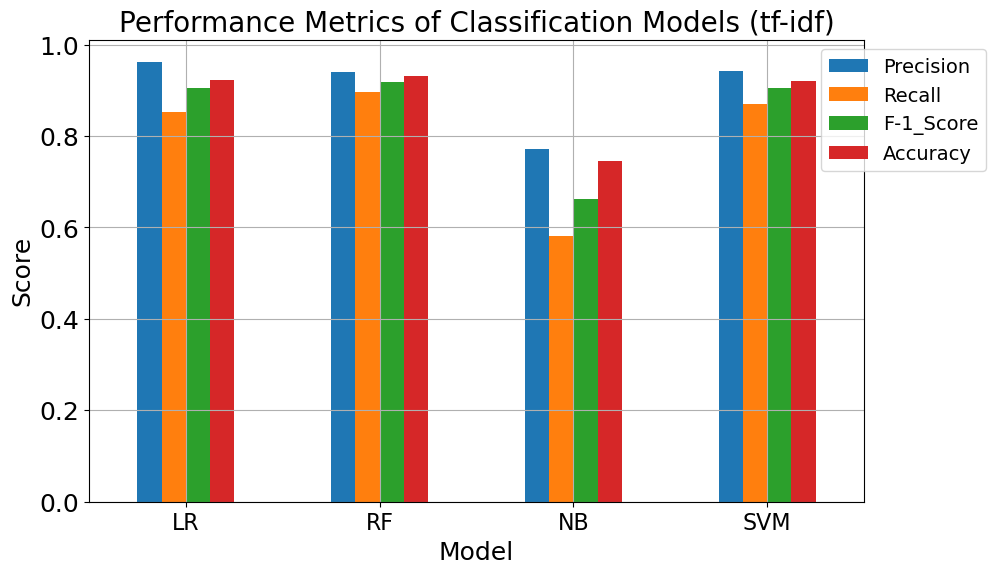

In [29]:
LR = 'Logistic-Regression'
RF = 'Random-Forest'
NB = 'Naive-Bayes'
SVM = 'Support-Vector-Machine'

df_metrics3.plot(kind='bar', x='Model', figsize=(10,6))

plt.title('Performance Metrics of Classification Models (tf-idf)', fontsize = 20)
plt.xlabel('Model', fontsize = 18)
plt.ylabel('Score', fontsize = 18)
plt.xticks(ticks=range(len(df_metrics3)), rotation = 0, fontsize = 16, labels=['LR', 'RF', 'NB', 'SVM'])
plt.legend(loc='upper center', bbox_to_anchor=(1.051, 1), fontsize = 14)

plt.grid()

## Feature Engineering: Sentiment Analysis

In [30]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Israt\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [31]:
sentiment_analyzer = vs()


def sentiment_analysis(c):   
    sentiment = sentiment_analyzer.polarity_scores(c)    
#     c_objs = count_tags(c)
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']] # c_objs[0], c_objs[1], c_objs[2]]
    
    #features = pandas.DataFrame(features)
    return features

def sentiment_analysis_array(c):
    features=[]
    for t in c:
        features.append(sentiment_analysis(t))
    return np.array(features)

final_features = sentiment_analysis_array(content)
#final_features

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3]}) 
#                             
new_features

,Neg,Pos,Neu,Compound
0,0.000,0.000,1.000,0.0000
1,0.000,0.316,0.684,0.4168
2,0.115,0.000,0.885,-0.2960
3,0.178,0.136,0.686,-0.6336
4,0.369,0.184,0.447,-0.5106
...,...,...,...,...
44156,0.000,0.153,0.847,0.4717
44157,0.425,0.000,0.575,-0.5719
44158,0.328,0.134,0.538,-0.5574
44159,0.291,0.000,0.709,-0.6955


In [32]:
# F2-Conctaenation of tf-idf scores and sentiment scores
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(44161, 10004)

In [33]:
modelling_features

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.316 ,  0.684 ,  0.4168],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.885 , -0.296 ],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.134 ,  0.538 , -0.5574],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.709 , -0.6955],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.747 , -0.5267]])

In [34]:
final_features

array([[ 0.    ,  0.    ,  1.    ,  0.    ],
       [ 0.    ,  0.316 ,  0.684 ,  0.4168],
       [ 0.115 ,  0.    ,  0.885 , -0.296 ],
       ...,
       [ 0.328 ,  0.134 ,  0.538 , -0.5574],
       [ 0.291 ,  0.    ,  0.709 , -0.6955],
       [ 0.253 ,  0.    ,  0.747 , -0.5267]])

## Model Implementation

In [35]:
# Running the model Using sentiment analysis
X = pd.DataFrame(final_features)
y = df['Label'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx +=1
df_metrics.loc[idx] = ['LogisticRegression', 'sentiment-analysis', precision, recall, f1, accuracy]

In [36]:
#Confusion Matrix for Sentiment Analysis 
confusion_matrix2 = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((2,2))

for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix2[i,:]/float(confusion_matrix2[i,:].sum())
    
names=['Hateful','Non-Hateful']

confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)

In [37]:
X = pd.DataFrame(final_features)
y = df['Label'].astype(int)

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

rf = RandomForestClassifier().fit(X_train_bow,y_train)

y_preds = rf.predict(X_test_bow)

precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx +=1
df_metrics.loc[idx] = ['RandomForestClassifier', 'sentiment-analysis', precision, recall, f1, accuracy]

In [38]:
#Confusion Matrix for Sentiment Analysis 
confusion_matrix2 = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((2,2))

for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix2[i,:]/float(confusion_matrix2[i,:].sum())
    
names=['Hateful','Non-Hateful']

confusion_df1 = pd.DataFrame(matrix_proportions, index=names,columns=names)

In [39]:
X = pd.DataFrame(final_features)
y = df['Label'].astype(int)

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

nb=GaussianNB().fit(X_train_bow,y_train)

y_preds = nb.predict(X_test_bow)

precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx +=1
df_metrics.loc[idx] = ['Naive-Bayes', 'sentiment-analysis', precision, recall, f1, accuracy]

In [40]:
#Confusion Matrix for Sentiment Analysis 
confusion_matrix2 = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((2,2))

for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix2[i,:]/float(confusion_matrix2[i,:].sum())
    
names=['Hateful','Non-Hateful']

confusion_df2 = pd.DataFrame(matrix_proportions, index=names,columns=names)

In [41]:
X = pd.DataFrame(final_features)
y = df['Label'].astype(int)

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

support =LinearSVC(random_state=20).fit(X_train_bow,y_train)

precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx +=1
df_metrics.loc[idx] = ['SVM', 'sentiment-analysis', precision, recall, f1, accuracy]

In [42]:
#Confusion Matrix for Sentiment Analysis 
confusion_matrix2 = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((2,2))

for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix2[i,:]/float(confusion_matrix2[i,:].sum())
    
names=['Hateful','Non-Hateful']

confusion_df3 = pd.DataFrame(matrix_proportions, index=names,columns=names)

## Performance Measurement for Sentiment Analysis

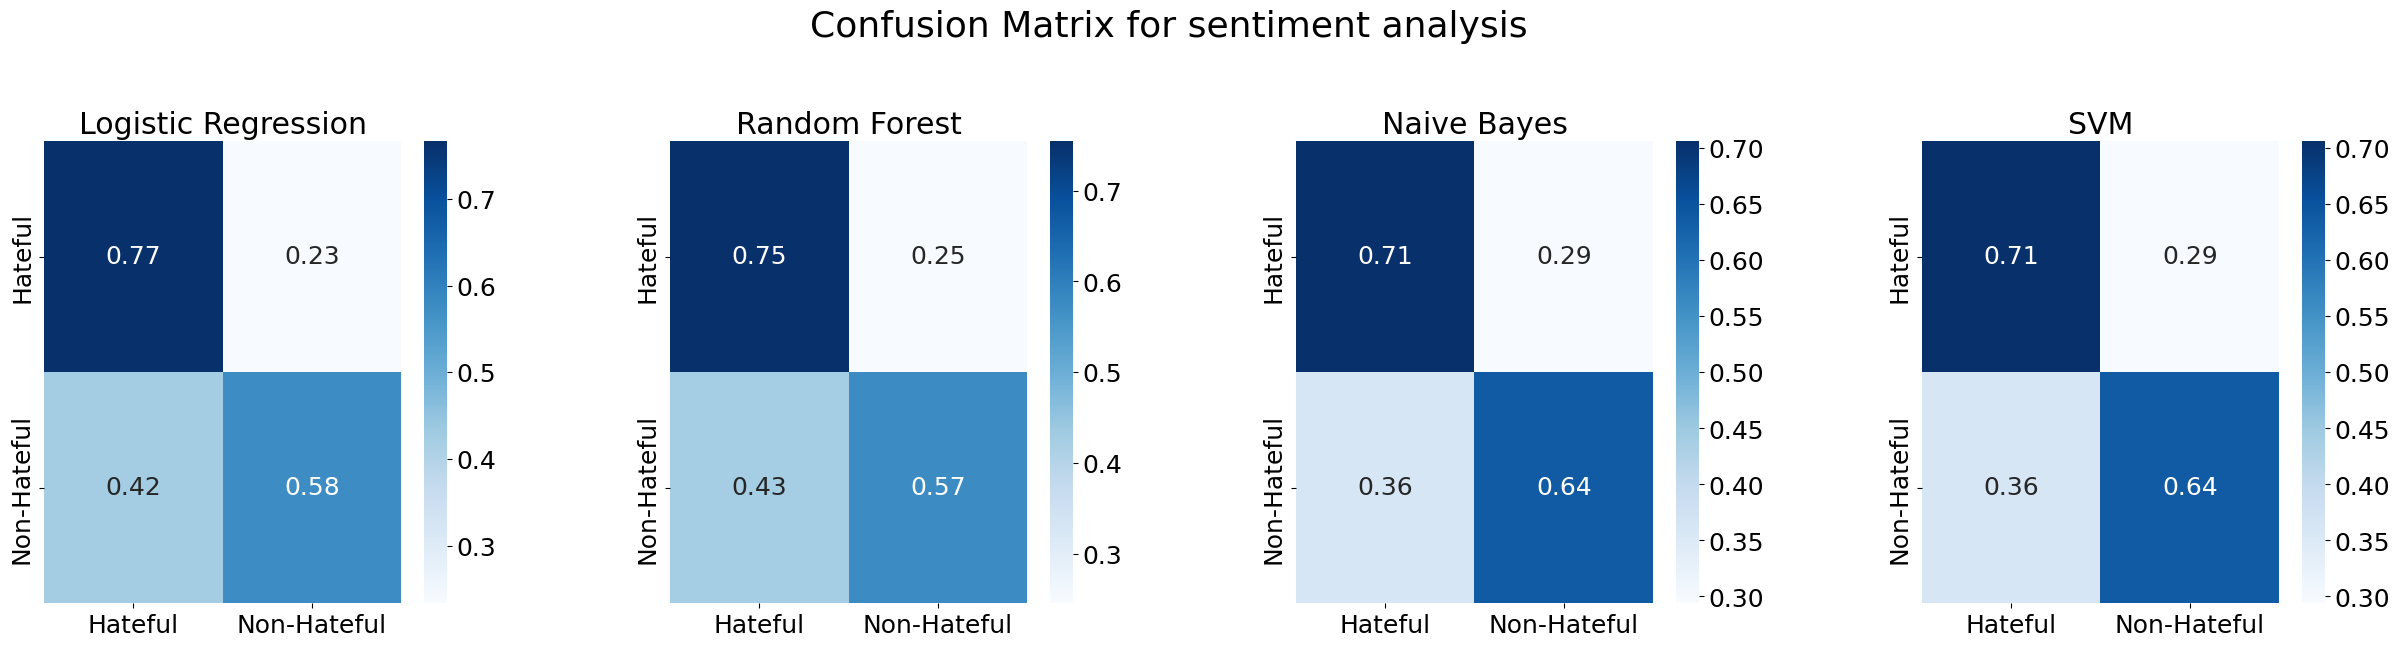

In [43]:
# Create a figure with four subplots in a row
fig, axs = plt.subplots(1, 4, figsize=(30, 6 ))

# Set the font size
plt.rcParams.update({'font.size': 18})

# Plot each confusion matrix on a separate subplot
sns.heatmap(confusion_df, annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(confusion_df1, annot=True, cmap='Blues', ax=axs[1])
sns.heatmap(confusion_df2, annot=True, cmap='Blues', ax=axs[2])
sns.heatmap(confusion_df3, annot=True, cmap='Blues', ax=axs[3])

# Set titles for each subplot
axs[0].set_title('Logistic Regression')
axs[1].set_title('Random Forest')
axs[2].set_title('Naive Bayes')
axs[3].set_title('SVM')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace = 0.4)
plt.savefig('sentiment_only_confusion.png')
fig.suptitle('Confusion Matrix for sentiment analysis\n\n', fontsize = 26, y = 1.1)

# Show the plot
plt.show()

In [44]:
df_metrics4 = df_metrics.loc[df_metrics['Feature'] == 'sentiment-analysis']
df_metrics4

,Model,Feature,Precision,Recall,F-1_Score,Accuracy
4,LogisticRegression,sentiment-analysis,0.650416,0.575789,0.610832,0.684365
5,RandomForestClassifier,sentiment-analysis,0.638198,0.574211,0.604516,0.676780
6,Naive-Bayes,sentiment-analysis,0.621158,0.638158,0.629543,0.676893
7,SVM,sentiment-analysis,0.621158,0.638158,0.629543,0.676893


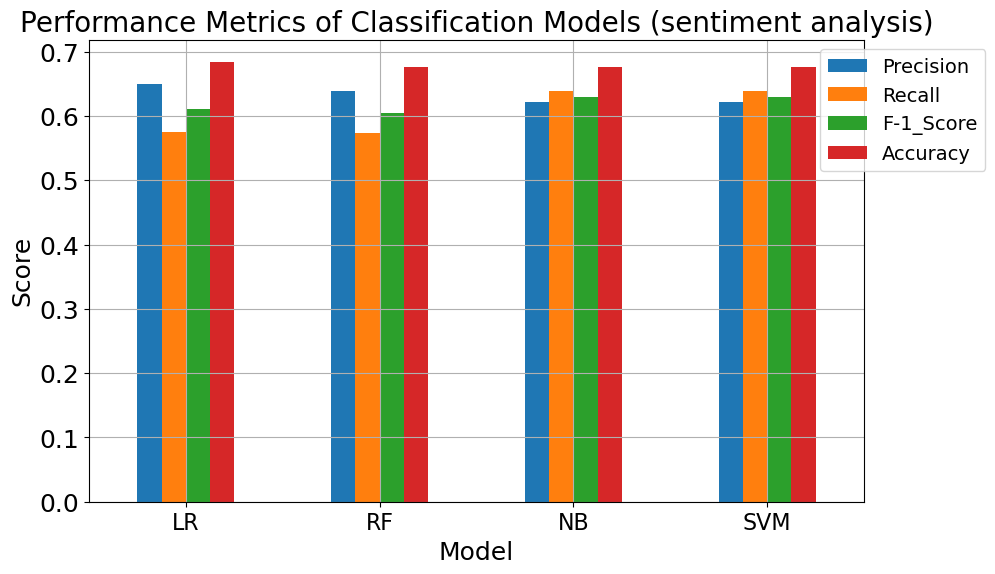

In [45]:
LR = 'Logistic-Regression'
RF = 'Random-Forest'
NB = 'Naive-Bayes'
SVM = 'Support-Vector-Machine'
df_metrics4.plot(kind='bar', x='Model', figsize=(10,6))
# plt.title('Performance Metrics of Classification Models (Sentiment Analysis)', fontsize = 20)
plt.xlabel('Model', fontsize = 18)
plt.ylabel('Score', fontsize = 18)
plt.xticks(ticks=range(len(df_metrics3)), rotation = 0, fontsize = 16, labels=['LR', 'RF', 'NB', 'SVM'])
plt.legend(loc='upper center', bbox_to_anchor=(1.05, 1), fontsize = 14)
plt.title('Performance Metrics of Classification Models (sentiment analysis)', fontsize = 20)

plt.grid()


## Model Implementation for tf-idf with sentiment analysis

In [46]:
# Running the model Using TFIDF with sentiment analysis
X = pd.DataFrame(modelling_features)
y = df['Label'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_preds = model.predict(X_test_bow)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx +=1
df_metrics.loc[idx] = ['LogisticRegression', 'tf-idf-sentiment-analysis', precision, recall, f1, accuracy]

C:\Users\Israt\anaconda3\envs\MD2K_Lab\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
#Confusion Matrix for tf-idf with Sentiment Analysis 
confusion_matrix2 = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((2,2))

for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix2[i,:]/float(confusion_matrix2[i,:].sum())
    
names=['Hateful','Non-Hateful']

confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)

In [48]:
X = pd.DataFrame(modelling_features)
y = df['Label'].astype(int)

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

rf = RandomForestClassifier().fit(X_train_bow,y_train)

y_preds = rf.predict(X_test_bow)

# performance metrics
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx +=1
df_metrics.loc[idx] = ['RandomForestClassifier', 'tf-idf-sentiment-analysis', precision, recall, f1, accuracy]

In [49]:
#Confusion Matrix for tf-idf with Sentiment Analysis 
confusion_matrix2 = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((2,2))

for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix2[i,:]/float(confusion_matrix2[i,:].sum())
    
names=['Hateful','Non-Hateful']

confusion_df1 = pd.DataFrame(matrix_proportions, index=names,columns=names)

In [50]:
X = pd.DataFrame(modelling_features)
y = df['Label'].astype(int)

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

nb=GaussianNB().fit(X_train_bow,y_train)

y_preds = nb.predict(X_test_bow)

precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx +=1
df_metrics.loc[idx] = ['Naive-Bayes', 'tf-idf-sentiment-analysis', precision, recall, f1, accuracy]

In [51]:
#Confusion Matrix for tf-idf with Sentiment Analysis 
confusion_matrix2 = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((2,2))

for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix2[i,:]/float(confusion_matrix2[i,:].sum())
    
names=['Hateful','Non-Hateful']

confusion_df2 = pd.DataFrame(matrix_proportions, index=names,columns=names)

In [52]:
X = pd.DataFrame(modelling_features)
y = df['Label'].astype(int)

X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

support =LinearSVC(random_state=20).fit(X_train_bow,y_train)

precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
accuracy = accuracy_score(y_test, y_preds)

idx +=1
df_metrics.loc[idx] = ['SVM', 'tf-idf-sentiment-analysis', precision, recall, f1, accuracy]

In [53]:
#Confusion Matrix for tf-idf with Sentiment Analysis 
confusion_matrix2 = confusion_matrix(y_test, y_preds)
matrix_proportions = np.zeros((2,2))

for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix2[i,:]/float(confusion_matrix2[i,:].sum())
    
names=['Hateful','Non-Hateful']

confusion_df3 = pd.DataFrame(matrix_proportions, index=names,columns=names)

## Performance metrics for tf-idf with sentiment analysis

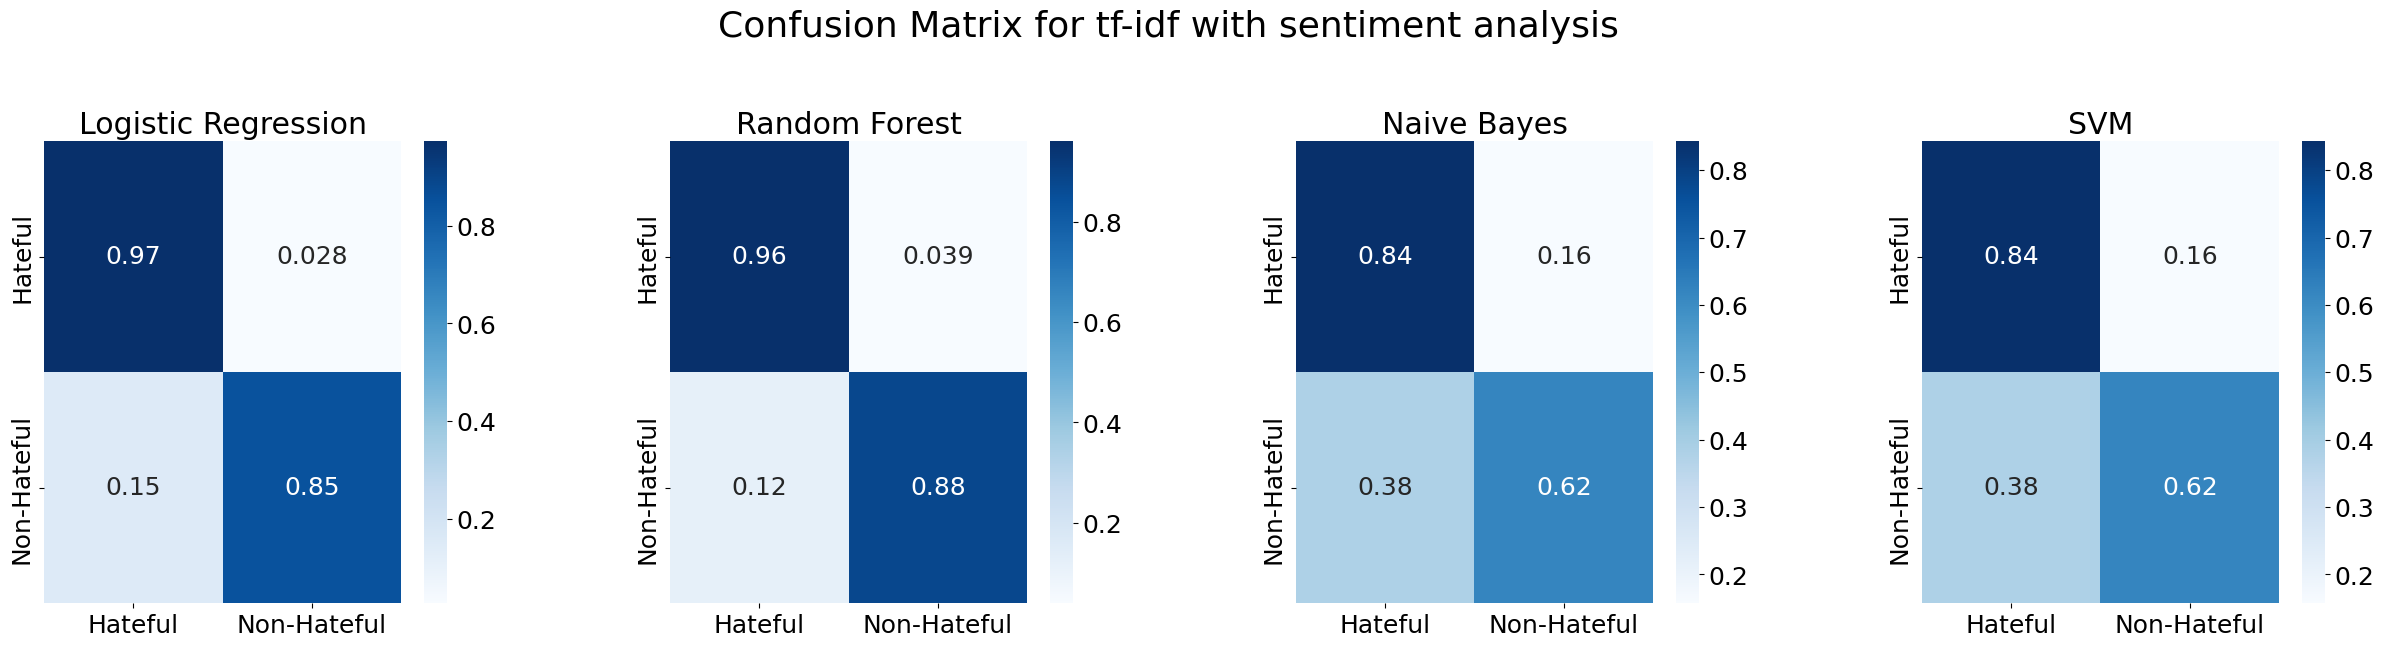

In [54]:
# Create a figure with four subplots in a row
fig, axs = plt.subplots(1, 4, figsize=(30, 6 ))

# Set the font size
plt.rcParams.update({'font.size': 18})

# Plot each confusion matrix on a separate subplot
sns.heatmap(confusion_df, annot=True, cmap='Blues', ax=axs[0])
sns.heatmap(confusion_df1, annot=True, cmap='Blues', ax=axs[1])
sns.heatmap(confusion_df2, annot=True, cmap='Blues', ax=axs[2])
sns.heatmap(confusion_df3, annot=True, cmap='Blues', ax=axs[3])

# Set titles for each subplot
axs[0].set_title('Logistic Regression')
axs[1].set_title('Random Forest')
axs[2].set_title('Naive Bayes')
axs[3].set_title('SVM')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4, hspace = 0.4)
plt.savefig('tf_idf_sentiment_confusion.png')
fig.suptitle('Confusion Matrix for tf-idf with sentiment analysis\n\n', fontsize = 26, y = 1.1)

# Show the plot
plt.show()


In [55]:
df_metrics5 = df_metrics.loc[df_metrics['Feature'] == 'tf-idf-sentiment-analysis']
df_metrics5

,Model,Feature,Precision,Recall,F-1_Score,Accuracy
8,LogisticRegression,tf-idf-sentiment-analysis,0.958754,0.850263,0.901255,0.919846
9,RandomForestClassifier,tf-idf-sentiment-analysis,0.944837,0.878947,0.910702,0.925846
10,Naive-Bayes,tf-idf-sentiment-analysis,0.748650,0.620000,0.678278,0.746972
11,SVM,tf-idf-sentiment-analysis,0.748650,0.620000,0.678278,0.746972


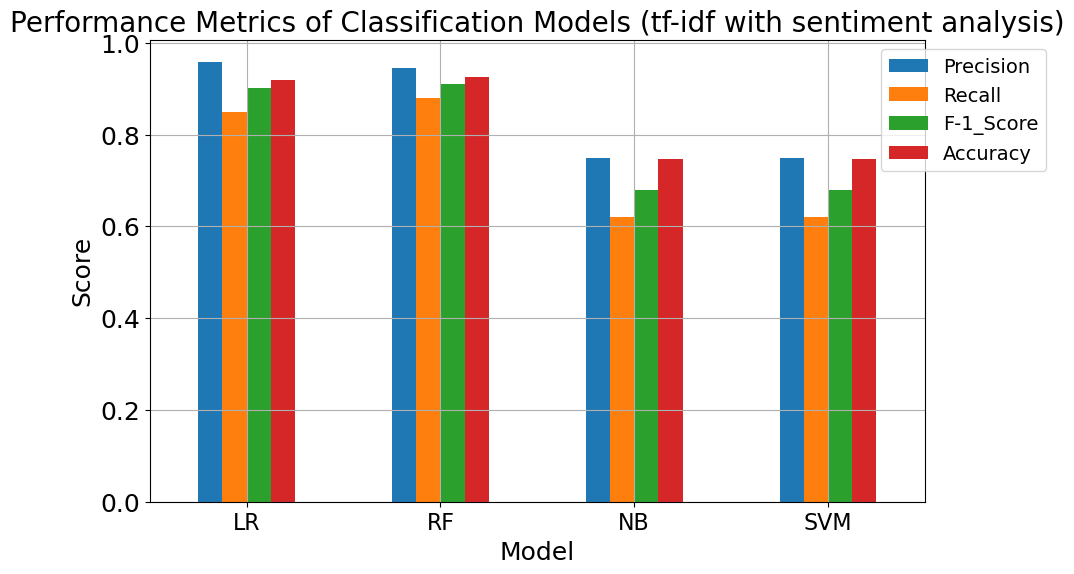

In [56]:
LR = 'Logistic-Regression'
RF = 'Random-Forest'
NB = 'Naive-Bayes'
SVM = 'Support-Vector-Machine'

df_metrics5.plot(kind='bar', x='Model', figsize=(10,6))

plt.xlabel('Model', fontsize = 18)
plt.ylabel('Score', fontsize = 18)
plt.xticks(ticks=range(len(df_metrics3)), rotation = 0, fontsize = 16, labels=['LR', 'RF', 'NB', 'SVM'])
plt.legend(loc='upper center', bbox_to_anchor=(1.05, 1), fontsize = 14)

plt.title('Performance Metrics of Classification Models (tf-idf with sentiment analysis)', fontsize = 20)
plt.grid()


## Dataframe with the performance metrics for 3 types of implementation

In [57]:
metrics6 = pd.DataFrame()
metrics6 = metrics6.append(df_metrics2)
metrics6 = metrics6.append(df_metrics4)
metrics6 = metrics6.append(df_metrics5)
metrics6

,Model,Feature,Precision,Recall,F-1_Score,Accuracy
0,LogisticRegression,td-idf,0.962567,0.852632,0.904270,0.922337
1,RandomForestClassifier,td-idf,0.939829,0.896053,0.917419,0.930601
2,Naive-Bayes,td-idf,0.771648,0.581579,0.663265,0.745953
3,SVM,td-idf,0.942637,0.869211,0.904436,0.920978
4,LogisticRegression,sentiment-analysis,0.650416,0.575789,0.610832,0.684365
5,RandomForestClassifier,sentiment-analysis,0.638198,0.574211,0.604516,0.676780
6,Naive-Bayes,sentiment-analysis,0.621158,0.638158,0.629543,0.676893
7,SVM,sentiment-analysis,0.621158,0.638158,0.629543,0.676893
8,LogisticRegression,tf-idf-sentiment-analysis,0.958754,0.850263,0.901255,0.919846
9,RandomForestClassifier,tf-idf-sentiment-analysis,0.944837,0.878947,0.910702,0.925846


In [58]:
metrics6.sort_values(['Accuracy', 'F-1_Score', 'Precision', 'Recall'])

,Model,Feature,Precision,Recall,F-1_Score,Accuracy
5,RandomForestClassifier,sentiment-analysis,0.638198,0.574211,0.604516,0.676780
6,Naive-Bayes,sentiment-analysis,0.621158,0.638158,0.629543,0.676893
7,SVM,sentiment-analysis,0.621158,0.638158,0.629543,0.676893
4,LogisticRegression,sentiment-analysis,0.650416,0.575789,0.610832,0.684365
2,Naive-Bayes,td-idf,0.771648,0.581579,0.663265,0.745953
10,Naive-Bayes,tf-idf-sentiment-analysis,0.748650,0.620000,0.678278,0.746972
11,SVM,tf-idf-sentiment-analysis,0.748650,0.620000,0.678278,0.746972
8,LogisticRegression,tf-idf-sentiment-analysis,0.958754,0.850263,0.901255,0.919846
3,SVM,td-idf,0.942637,0.869211,0.904436,0.920978
0,LogisticRegression,td-idf,0.962567,0.852632,0.904270,0.922337
